# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [2]:
import os
# Set GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

/home/jupyter-st125404/.local/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


('3.4.1', '4.35.2', '2.6.0+cu124')

In [4]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [ ]:


raw_datasets = datasets.load_dataset('google-research-datasets/go_emotions')
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [6]:
label_list = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust",
    "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love",
    "nervousness", "optimism", "pride", "realization", "relief", "remorse", "sadness",
    "surprise", "neutral"
]

# Map to label2id
label2id = {label: i for i, label in enumerate(label_list)}
print(label2id)

{'admiration': 0, 'amusement': 1, 'anger': 2, 'annoyance': 3, 'approval': 4, 'caring': 5, 'confusion': 6, 'curiosity': 7, 'desire': 8, 'disappointment': 9, 'disapproval': 10, 'disgust': 11, 'embarrassment': 12, 'excitement': 13, 'fear': 14, 'gratitude': 15, 'grief': 16, 'joy': 17, 'love': 18, 'nervousness': 19, 'optimism': 20, 'pride': 21, 'realization': 22, 'relief': 23, 'remorse': 24, 'sadness': 25, 'surprise': 26, 'neutral': 27}


In [7]:
print(raw_datasets['train'].features)

{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None), 'id': Value(dtype='string', id=None)}


In [8]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

## 2. Model & Tokenization

In [9]:
import numpy as np 
# Convert the nested list to a flat NumPy array
all_labels = np.concatenate(raw_datasets['train']['labels'])

# Get the number of unique labels
num_labels = np.unique(all_labels).size
print(num_labels)

28


<img src = "figures/BERT_embed.png" width=500>

In [10]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

/home/jupyter-st125404/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jupyter-st125404/.local/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/jupyter-st125404/.local/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [11]:
# Define the tokenize function
# Tokenize and process labels
def tokenize_function(examples):
    result = tokenizer(examples['text'], max_length=128, truncation=True)
    labels_binary = np.zeros((len(examples['text']), num_labels), dtype=int)
    for i, label_list in enumerate(examples['labels']):
        for label in label_list:
            labels_binary[i, label] = 1
    result['labels'] = labels_binary.tolist()
    return result



In [12]:
# Tokenize the dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Inspect the result
print(tokenized_datasets)
print(tokenized_datasets['train'][0])

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'id': 'eebbqej', 'input_ids': [101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000, 5660, 2870, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
# list(task_to_keys[task_name])
# Define task_to_keys for GoEmotions (single-text task)
task_to_keys = {
    'go_emotions': ('text', None)  # Single input column, no second sentence
}

# Set the task name
task_name = 'go_emotions'

# Get the columns, filtering out None
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
print(column_dataset)

['text']


In [14]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["id"])
#rename column : 'labels'
# tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})

In [15]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102])

In [16]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] my favourite food is anything i didn't have to cook myself. [SEP]"

## 4. Preparing the dataloader

In [17]:
from transformers import DataCollatorWithPadding
# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')#Data collator that will dynamically pad the inputs received.

In [18]:
# Assuming tokenized_datasets is already created (from your previous tokenization step)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(40000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [20]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# Define the data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

# Create the DataLoader
train_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)

# Test the batch
for batch in train_dataloader:
    print(batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape)
    break

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([8, 28]) torch.Size([8, 26]) torch.Size([8, 26])


## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [21]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "admiration",
    "1": "amusement",
    "2": "anger",
    "3": "annoyance",
    "4": "approval",
    "5": "caring",
    "6": "confusion",
    "7": "curiosity",
    "8": "desire",
    "9": "disappointment",
    "10": "disapproval",
    "11": "disgust",
    "12": "embarrassment",
    "13": "excitement",
    "14": "fear",
    "15": "gratitude",
    "16": "grief",
    "17": "joy",
    "18": "love",
    "19": "nervousness",
    "20": "optimism",
    "21": "pride",
    "22": "realization",
    "23": "relief",
    "24": "remorse",
    "25": "sadness",
    "26": "surprise",
    "27": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "admiration": 0,
 

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [22]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [23]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [24]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module
def distill_bert_weights(
    teacher: Module,
    student: Module,
    layer_strategy: str = 'even'  # 'odd' or 'even'
) -> None:
    """
    Recursively copies weights from the teacher to the student, selecting specific layers.
    Args:
        teacher: The teacher model (e.g., 12-layer BERT).
        student: The student model (e.g., 6-layer BERT).
        layer_strategy: 'odd' (layers 1, 3, 5, 7, 9, 11) or 'even' (layers 2, 4, 6, 8, 10, 12).
    """
    # If the part is an entire BERT model, unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part, layer_strategy)
    # If the part is an encoder, copy the selected layers
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())]  # 12 layers
        student_encoding_layers = [layer for layer in next(student.children())]  # 6 layers
        
        # Define layer indices based on strategy (0-indexed)
        if layer_strategy == 'odd':
            teacher_layer_indices = [0, 2, 4, 6, 8, 10]  # Layers 1, 3, 5, 7, 9, 11
        elif layer_strategy == 'even':
            teacher_layer_indices = [1, 3, 5, 7, 9, 11]  # Layers 2, 4, 6, 8, 10, 12
        else:
            raise ValueError("layer_strategy must be 'odd' or 'even'")
        
        # Copy weights from selected teacher layers to student layers
        for student_idx, teacher_idx in enumerate(teacher_layer_indices):
            student_encoding_layers[student_idx].load_state_dict(teacher_encoding_layers[teacher_idx].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [26]:
model = distill_bert_weights(teacher=teacher_model, student=model)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters :', count_parameters(model))

Teacher parameters : 109503772
Student parameters : 66976540


In [28]:
count_parameters(model)/count_parameters(teacher_model) * 100

61.16368301906532

In [29]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [30]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [31]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [32]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [33]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [34]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [35]:
# !pip3 install evaluate

In [36]:
import numpy as np
import evaluate

# Load metrics suitable for multi-label classification
metric_f1 = evaluate.load("f1", config_name="multilabel")
metric_precision = evaluate.load("precision", config_name="multilabel")
metric_recall = evaluate.load("recall", config_name="multilabel")

# Optionally, define task_name if not already set
task_name = "go_emotions"  # From your previous code, if applicable

# You can still use a conditional if task_name is dynamic, but it's not tied to GLUE
if task_name == "go_emotions":
    # Use multi-label metrics
    metrics = {
        "f1": metric_f1,
        "precision": metric_precision,
        "recall": metric_recall
    }
else:
    # Fallback for single-label tasks (if needed elsewhere)
    metrics = {"accuracy": evaluate.load("accuracy")}

print("Loaded metrics:", list(metrics.keys()))

Loaded metrics: ['f1', 'precision', 'recall']


## 9. Train

In [63]:
# Create and distill students

from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertConfig, AdamW, get_scheduler, DataCollatorWithPadding
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, num_labels=num_labels, id2label=id2label, label2id=label2id, problem_type="multi_label_classification"
)
student_config = BertConfig.from_dict(teacher_model.config.to_dict())
student_config.num_hidden_layers //= 2  # Reduce from 12 to 6
student_config.problem_type = "multi_label_classification"  # Explicitly set for multi-label


/home/jupyter-st125404/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
student_odd = AutoModelForSequenceClassification.from_config(student_config)
distill_bert_weights(teacher=teacher_model, student=student_odd, layer_strategy='odd')  # Odd layers

student_even = AutoModelForSequenceClassification.from_config(student_config)
distill_bert_weights(teacher=teacher_model, student=student_even, layer_strategy='even')  # Even layers


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [65]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)
student_odd.to(device)
student_even.to(device)

optimizer_odd = AdamW(student_odd.parameters(), lr=5e-5)
optimizer_even = AdamW(student_even.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler_odd = get_scheduler("linear", optimizer=optimizer_odd, num_warmup_steps=0, num_training_steps=num_training_steps)
lr_scheduler_even = get_scheduler("linear", optimizer=optimizer_even, num_warmup_steps=0, num_training_steps=num_training_steps)


/home/jupyter-st125404/.local/lib/python3.12/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  optimizer: Optimizer,


In [66]:

criterion_div = torch.nn.KLDivLoss(reduction="batchmean")
criterion_cos = torch.nn.CosineEmbeddingLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()

In [67]:
metrics = {
    "f1": evaluate.load("f1", config_name="multilabel"),
    "precision": evaluate.load("precision", config_name="multilabel"),
    "recall": evaluate.load("recall", config_name="multilabel")
}


In [72]:
print(f"Training batches: {len(train_dataloader)}")
print(f"Evaluation batches: {len(eval_dataloader)}")


Training batches: 5000
Evaluation batches: 32


In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm

student_odd = AutoModelForSequenceClassification.from_config(student_config)
student_even = AutoModelForSequenceClassification.from_config(student_config)
distill_bert_weights(teacher=teacher_model, student=student_odd, layer_strategy='odd')
distill_bert_weights(teacher=teacher_model, student=student_even, layer_strategy='even')
student_odd.to(device)
student_even.to(device)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)  
progress_bar = tqdm(range(num_training_steps * 2))  # For both odd and even

# Training student_odd
eval_metrics_odd = {"f1": 0, "precision": 0, "recall": 0}
train_losses_odd = []
train_losses_cls_odd = []
train_losses_div_odd = []
train_losses_cos_odd = []
eval_losses_odd = []

for epoch in range(num_epochs):
    student_odd.train()  # student_odd is the model object here
    teacher_model.eval()
    train_loss_odd = train_loss_cls_odd = train_loss_div_odd = train_loss_cos_odd = 0
    
    for batch in train_dataloader:
        assert "labels" in batch, "Missing 'labels' in batch"  # Check labels in batch
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = student_odd(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits
        
        with torch.no_grad():
            output_teacher = teacher_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            teacher_logits = output_teacher.logits

        loss_cls = loss_fn(logits, batch["labels"].float())
        train_loss_cls_odd += loss_cls.item()
        
        student_log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=-1)
        loss_div = criterion_div(student_log_probs, teacher_probs)
        train_loss_div_odd += loss_div.item()

        loss_cos = criterion_cos(teacher_logits, logits, torch.ones(logits.size(0)).to(device))
        train_loss_cos_odd += loss_cos.item()
        loss = (loss_cls + loss_div + loss_cos) / 3
        train_loss_odd += loss.item()

        loss.backward()
        optimizer_odd.step()
        lr_scheduler_odd.step()
        optimizer_odd.zero_grad()
        progress_bar.update(1)

    print(f"Epoch {epoch+1} (Odd) - Avg train loss: {train_loss_odd / len(train_dataloader):.4f}")
    print(f"  - Loss_cls: {train_loss_cls_odd / len(train_dataloader):.4f}")
    print(f"  - Loss_div: {train_loss_div_odd / len(train_dataloader):.4f}")
    print(f"  - Loss_cos: {train_loss_cos_odd / len(train_dataloader):.4f}")

    train_losses_odd.append(train_loss_odd / len(train_dataloader))
    train_losses_cls_odd.append(train_loss_cls_odd / len(train_dataloader))
    train_losses_div_odd.append(train_loss_div_odd / len(train_dataloader))
    train_losses_cos_odd.append(train_loss_cos_odd / len(train_dataloader))

    # Eval metrics for student_odd
    student_odd.eval()
    eval_loss_odd = 0
    all_predictions_odd = []
    all_labels_odd = []

    with torch.no_grad():
        for batch in eval_dataloader:
            assert "labels" in batch, "Missing 'labels' in eval batch"  # Check eval batch
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = student_odd(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            loss_cls = loss_fn(logits, batch["labels"].float())
            eval_loss_odd += loss_cls.item()

            predictions = (torch.sigmoid(logits) > 0.5).int()
            all_predictions_odd.append(predictions.cpu().numpy())
            all_labels_odd.append(batch["labels"].cpu().numpy())

    all_predictions_odd = np.concatenate(all_predictions_odd, axis=0)
    all_labels_odd = np.concatenate(all_labels_odd, axis=0)

    eval_results_odd = {}
    for metric_name, metric in metrics.items():
        eval_results_odd[metric_name] = metric.compute(predictions=all_predictions_odd, references=all_labels_odd, average="micro")[metric_name]
        eval_metrics_odd[metric_name] += eval_results_odd[metric_name]

    eval_losses_odd.append(eval_loss_odd / len(eval_dataloader))
    print(f"Epoch {epoch+1} (Odd) - Eval loss: {eval_losses_odd[-1]:.4f}, F1: {eval_results_odd['f1']:.4f}, Precision: {eval_results_odd['precision']:.4f}, Recall: {eval_results_odd['recall']:.4f}")

print(f"Average Eval Metrics (Odd):")
for metric_name in eval_metrics_odd:
    print(f"  - {metric_name.capitalize()}: {eval_metrics_odd[metric_name] / num_epochs:.4f}")

# Training student_even
eval_metrics_even = {"f1": 0, "precision": 0, "recall": 0}
train_losses_even = []
train_losses_cls_even = []
train_losses_div_even = []
train_losses_cos_even = []
eval_losses_even = []

for epoch in range(num_epochs):
    student_even.train()  # student_even is the model object here
    teacher_model.eval()
    train_loss_even = train_loss_cls_even = train_loss_div_even = train_loss_cos_even = 0
    
    for batch in train_dataloader:
        assert "labels" in batch, "Missing 'labels' in batch"  # Check labels in batch
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = student_even(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits
        
        with torch.no_grad():
            output_teacher = teacher_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            teacher_logits = output_teacher.logits

        loss_cls = loss_fn(logits, batch["labels"].float())
        train_loss_cls_even += loss_cls.item()
        
        student_log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        teacher_probs = torch.nn.functional.softmax(teacher_logits, dim=-1)
        loss_div = criterion_div(student_log_probs, teacher_probs)
        train_loss_div_even += loss_div.item()

        loss_cos = criterion_cos(teacher_logits, logits, torch.ones(logits.size(0)).to(device))
        train_loss_cos_even += loss_cos.item()
        loss = (loss_cls + loss_div + loss_cos) / 3
        train_loss_even += loss.item()

        loss.backward()
        optimizer_even.step()
        lr_scheduler_even.step()
        optimizer_even.zero_grad()
        progress_bar.update(1)

    print(f"Epoch {epoch+1} (Even) - Avg train loss: {train_loss_even / len(train_dataloader):.4f}")
    print(f"  - Loss_cls: {train_loss_cls_even / len(train_dataloader):.4f}")
    print(f"  - Loss_div: {train_loss_div_even / len(train_dataloader):.4f}")
    print(f"  - Loss_cos: {train_loss_cos_even / len(train_dataloader):.4f}")

    train_losses_even.append(train_loss_even / len(train_dataloader))
    train_losses_cls_even.append(train_loss_cls_even / len(train_dataloader))
    train_losses_div_even.append(train_loss_div_even / len(train_dataloader))
    train_losses_cos_even.append(train_loss_cos_even / len(train_dataloader))

    # Eval metrics for student_even
    student_even.eval()
    eval_loss_even = 0
    all_predictions_even = []
    all_labels_even = []

    with torch.no_grad():
        for batch in eval_dataloader:
            assert "labels" in batch, "Missing 'labels' in eval batch"  # Check eval batch
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = student_even(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            loss_cls = loss_fn(logits, batch["labels"].float())
            eval_loss_even += loss_cls.item()

            predictions = (torch.sigmoid(logits) > 0.5).int()
            all_predictions_even.append(predictions.cpu().numpy())
            all_labels_even.append(batch["labels"].cpu().numpy())

    all_predictions_even = np.concatenate(all_predictions_even, axis=0)
    all_labels_even = np.concatenate(all_labels_even, axis=0)

    eval_results_even = {}
    for metric_name, metric in metrics.items():
        eval_results_even[metric_name] = metric.compute(predictions=all_predictions_even, references=all_labels_even, average="micro")[metric_name]
        eval_metrics_even[metric_name] += eval_results_even[metric_name]

    eval_losses_even.append(eval_loss_even / len(eval_dataloader))
    print(f"Epoch {epoch+1} (Even) - Eval loss: {eval_losses_even[-1]:.4f}, F1: {eval_results_even['f1']:.4f}, Precision: {eval_results_even['precision']:.4f}, Recall: {eval_results_even['recall']:.4f}")

print(f"Average Eval Metrics (Even):")
for metric_name in eval_metrics_even:
    print(f"  - {metric_name.capitalize()}: {eval_metrics_even[metric_name] / num_epochs:.4f}")

student_odd.save_pretrained("./student_odd_model1")
student_even.save_pretrained("./student_even_model1")
tokenizer.save_pretrained("./student_odd_model1")
tokenizer.save_pretrained("./student_even_model1")
print("Models saved: ./student_odd_model1 and ./student_even_model1")

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 1 (Odd) - Avg train loss: 0.5129
  - Loss_cls: 0.7404
  - Loss_div: 0.0809
  - Loss_cos: 0.7174
Epoch 1 (Odd) - Eval loss: 0.7374, F1: 0.0861, Precision: 0.0459, Recall: 0.6826
Epoch 2 (Odd) - Avg train loss: 0.5129
  - Loss_cls: 0.7405
  - Loss_div: 0.0809
  - Loss_cos: 0.7173
Epoch 2 (Odd) - Eval loss: 0.7374, F1: 0.0861, Precision: 0.0459, Recall: 0.6826
Average Eval Metrics (Odd):
  - F1: 0.0861
  - Precision: 0.0459
  - Recall: 0.6826
Epoch 1 (Even) - Avg train loss: 0.4470
  - Loss_cls: 0.7120
  - Loss_div: 0.0498
  - Loss_cos: 0.5791
Epoch 1 (Even) - Eval loss: 0.7094, F1: 0.0869, Precision: 0.0467, Recall: 0.6349
Epoch 2 (Even) - Avg train loss: 0.4475
  - Loss_cls: 0.7121
  - Loss_div: 0.0499
  - Loss_cos: 0.5806
Epoch 2 (Even) - Eval loss: 0.7094, F1: 0.0869, Precision: 0.0467, Recall: 0.6349
Average Eval Metrics (Even):
  - F1: 0.0869
  - Precision: 0.0467
  - Recall: 0.6349


In [89]:
print(train_loss)

31.82956489920616


In [47]:
import pickle

# Save the full models and tokenizer as .pkl files
with open("./student_odd_model.pkl", "wb") as f:
    pickle.dump(student_odd, f)
with open("./student_even_model.pkl", "wb") as f:
    pickle.dump(student_even, f)
with open("./tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Models and tokenizer saved as .pkl files: student_odd_model.pkl, student_even_model.pkl, tokenizer.pkl")

Models and tokenizer saved as .pkl files: student_odd_model.pkl, student_even_model.pkl, tokenizer.pkl


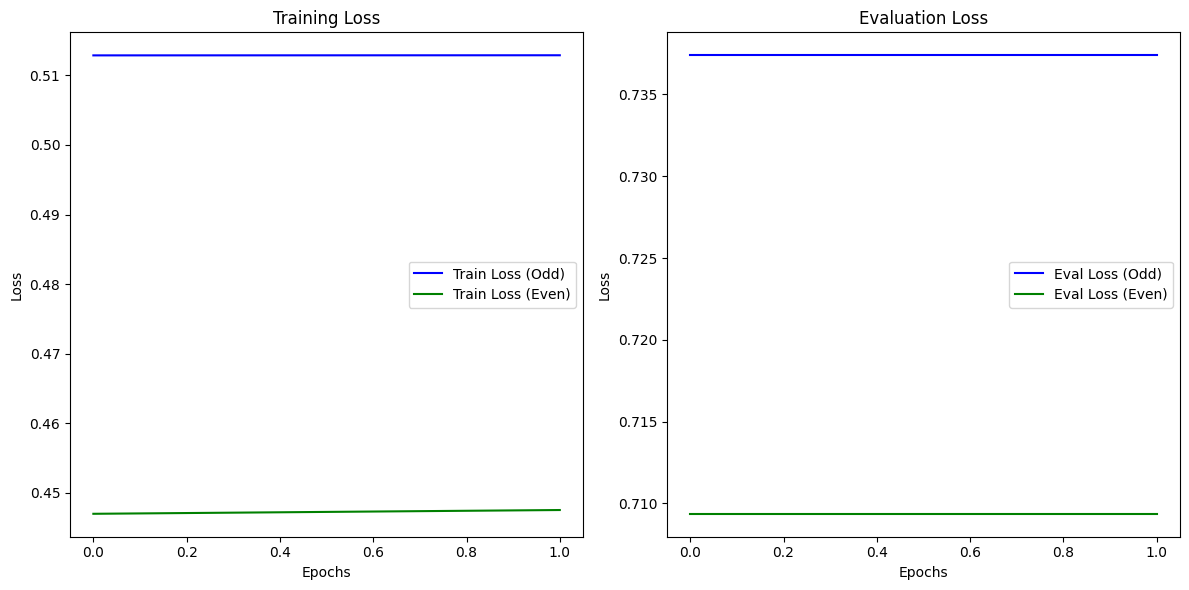

In [94]:
import matplotlib.pyplot as plt

# Plotting the losses for student_odd and student_even
plt.figure(figsize=(12, 6))

# Training Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_odd, label='Train Loss (Odd)', color='blue')
plt.plot(train_losses_even, label='Train Loss (Even)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Evaluation Losses
plt.subplot(1, 2, 2)
plt.plot(eval_losses_odd, label='Eval Loss (Odd)', color='blue')
plt.plot(eval_losses_even, label='Eval Loss (Even)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [92]:
import pickle
from transformers import AutoTokenizer

# Save the model with pickle
with open('./student_odd_model_updated.pkl', 'wb') as f:
    pickle.dump(student_odd, f)

with open('./student_even_model_updated.pkl', 'wb') as f:
    pickle.dump(student_even, f)

# Save the tokenizers
tokenizer.save_pretrained('./student_odd_model2')  # Save the tokenizer for student_odd
tokenizer.save_pretrained('./student_even_model2')  # Save the tokenizer for student_even

# Save the configuration of the models
student_odd.config.save_pretrained('./student_odd_model2')  # Save the config of student_odd
student_even.config.save_pretrained('./student_even_model2')  # Save the config of student_even

print("Models and tokenizers saved.")


Models and tokenizers saved.


### Appendix (Teacher Model)

In [97]:
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np

# Ensure teacher_model is moved to the correct device
teacher_model.to(device)

# Hyperparameters
lr = 5e-5
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

# Optimizer (no scheduler in your original code; I removed lr_scheduler)
optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

# Loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# To track training and evaluation metrics
train_losses = []
eval_losses = []
eval_metrics = {"accuracy": 0}

# Initialize the progress bar
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    teacher_model.train()
    train_loss = 0
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass (do not pass labels to compute internal loss)
        output_teacher = teacher_model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch["token_type_ids"],
            labels=None  # Set to None to get logits only
        )
        
        # Compute multi-label loss
        logits = output_teacher.logits  # Shape: [batch_size, num_labels]
        labels = batch["labels"].float()  # Convert to float for BCEWithLogitsLoss
        loss = loss_fn(logits, labels)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        progress_bar.update(1)

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}: Train loss {avg_train_loss:.4f}')

    # Evaluation
    teacher_model.eval()
    eval_loss = 0
    all_predictions = []
    all_labels = []

    for step, batch in enumerate(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = teacher_model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
                labels=None
            )
        
        # Compute evaluation loss
        logits = outputs.logits
        labels = batch["labels"].float()
        eval_loss += loss_fn(logits, labels).item()

        # Get predictions (apply sigmoid and threshold at 0.5)
        predictions = (torch.sigmoid(logits) > 0.5).int()  # Shape: [batch_size, num_labels]
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_eval_loss = eval_loss / len(eval_dataloader)
    eval_losses.append(avg_eval_loss)

    # Flatten lists for accuracy computation
    all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: [total_samples, num_labels]
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: [total_samples, num_labels]

    # Compute evaluation accuracy (exact match ratio for multi-label)
    eval_accuracy = accuracy_score(all_labels, all_predictions)
    eval_metrics["accuracy"] += eval_accuracy

    print(f"Epoch {epoch+1}: Eval loss {avg_eval_loss:.4f}, Eval Acc {eval_accuracy:.4f}")

# Average metrics over all epochs
avg_eval_accuracy = eval_metrics["accuracy"] / num_epochs
print(f'Avg Eval Accuracy: {avg_eval_accuracy:.4f}')

# Optionally save the model after training
# teacher_model.save_pretrained('./teacher_model')
# tokenizer.save_pretrained('./teacher_model')

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1: Train loss 0.1070
Epoch 1: Eval loss 0.0880, Eval Acc 0.4000
Epoch 2: Train loss 0.0825
Epoch 2: Eval loss 0.0848, Eval Acc 0.4480
Epoch 3: Train loss 0.0690
Epoch 3: Eval loss 0.0893, Eval Acc 0.4460
Avg Eval Accuracy: 0.4313


In [43]:
torch.cuda.empty_cache()

In [98]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import numpy as np

# Ensure models are on the correct device
student_odd.to(device)
student_even.to(device)
teacher_model.to(device)  # Optional, for comparison

# Loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Use the existing test_dataloader from your notebook (cell 19)
# test_dataloader = DataLoader(small_test_dataset, batch_size=32, collate_fn=data_collator)
# Already defined, so no need to redefine unless you want to change batch_size

# Function to compute test loss for a given model
def compute_test_loss(model, dataloader, loss_fn, device):
    model.eval()
    total_test_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test Set"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
                labels=None  # Get logits only
            )
            logits = outputs.logits  # Shape: [batch_size, num_labels]
            labels = batch["labels"].float()  # Convert to float for BCEWithLogitsLoss
            loss = loss_fn(logits, labels)
            total_test_loss += loss.item()
            num_batches += 1
    
    avg_test_loss = total_test_loss / num_batches
    return avg_test_loss

# Compute test loss for both student models
print("Computing test loss for student_odd...")
test_loss_odd = compute_test_loss(student_odd, test_dataloader, loss_fn, device)
print(f"Student Odd Test Loss: {test_loss_odd:.4f}")

print("Computing test loss for student_even...")
test_loss_even = compute_test_loss(student_even, test_dataloader, loss_fn, device)
print(f"Student Even Test Loss: {test_loss_even:.4f}")

# Optionally compute test loss for teacher model for comparison
print("Computing test loss for teacher_model...")
test_loss_teacher = compute_test_loss(teacher_model, test_dataloader, loss_fn, device)
print(f"Teacher Model Test Loss: {test_loss_teacher:.4f}")

Computing test loss for student_odd...


Evaluating Test Set:   0%|          | 0/32 [00:00<?, ?it/s]

Student Odd Test Loss: 0.7386
Computing test loss for student_even...


Evaluating Test Set:   0%|          | 0/32 [00:00<?, ?it/s]

Student Even Test Loss: 0.7096
Computing test loss for teacher_model...


Evaluating Test Set:   0%|          | 0/32 [00:00<?, ?it/s]

Teacher Model Test Loss: 0.0884


In [ ]:
import torch
from transformers import AutoTokenizer

# Ensure models are on the correct device
teacher_model.to(device)
student_odd.to(device)
student_even.to(device)


# Function for inference
def predict_emotions(text, model, tokenizer, id2label, device, threshold=0.5):
    model.eval()
    
    # Tokenize the input text
    inputs = tokenizer(
        text,
        max_length=128,
        truncation=True,
        padding=True,
        return_tensors="pt"  # Return PyTorch tensors
    )
    
    # Move inputs to the correct device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Shape: [1, num_labels]
    
    # Convert logits to probabilities
    probs = torch.sigmoid(logits).squeeze(0)  # Shape: [num_labels]
    
    # Apply threshold to get predicted labels
    predicted_labels = (probs > threshold).int()
    
    # Get the emotion names
    emotions = [id2label[i] for i, val in enumerate(predicted_labels) if val == 1]
    
    # Return probabilities and emotions
    return probs.cpu().numpy(), emotions

# Example text for inference
example_texts = [
    "I’m so happy to see you all again!",
    "This is absolutely disgusting and frustrating.",
    "Wow, I didn’t expect that at all!"
]

# Perform inference with all models
models = {
    "Teacher Model": teacher_model,
    "Student Odd": student_odd,
    "Student Even": student_even
}

for text in example_texts:
    print(f"\nInput Text: '{text}'")
    for model_name, model in models.items():
        probs, emotions = predict_emotions(text, model, tokenizer, id2label, device)
        print(f"{model_name}:")
        print(f"  Predicted Emotions: {emotions if emotions else 'None'}")
        print(f"  Probabilities: {[f'{id2label[i]}: {prob:.3f}' for i, prob in enumerate(probs) if prob > 0.1]}")


Input Text: 'I’m so happy to see you all again!'
Teacher Model:
  Predicted Emotions: ['joy']
  Probabilities: ['joy: 0.884']
Student Odd:
  Predicted Emotions: ['amusement', 'confusion', 'curiosity', 'desire', 'disapproval', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'pride', 'realization', 'relief', 'remorse', 'surprise', 'neutral']
  Probabilities: ['admiration: 0.303', 'amusement: 0.601', 'anger: 0.469', 'annoyance: 0.480', 'approval: 0.378', 'caring: 0.414', 'confusion: 0.502', 'curiosity: 0.590', 'desire: 0.614', 'disappointment: 0.411', 'disapproval: 0.546', 'disgust: 0.298', 'embarrassment: 0.528', 'excitement: 0.549', 'fear: 0.541', 'gratitude: 0.605', 'grief: 0.567', 'joy: 0.633', 'love: 0.635', 'nervousness: 0.535', 'optimism: 0.427', 'pride: 0.582', 'realization: 0.614', 'relief: 0.566', 'remorse: 0.552', 'sadness: 0.424', 'surprise: 0.500', 'neutral: 0.614']
Student Even:
  Predicted Emotions: ['amusement', 'curiosity', 'des